Import and helpers functions
---
- `get_driving_log` reads the csv that contains all the image names and steering angles
- `generator` is a function that creates the image generator (used for both training and validation sets)

In [1]:
import csv
import cv2
import numpy as np
import sklearn
import random

In [38]:
def get_driving_log(path):
    lines = []
    with open(path + 'driving_log.csv') as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            lines.append(line)
            
    return lines

In [62]:
def generator(path, samples, batch_size=128, shuffle=True):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        if shuffle:
            samples = sklearn.utils.shuffle(samples)
            
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                for image_nb in [0, 1, 2]:
                    name = path + 'IMG/'+ batch_sample[image_nb].split('/')[-1]
                    image = cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB)
                    shift_dict = {0: 0, 1: 0.3, 2: -0.3} 
                    angle = float(batch_sample[3]) + shift_dict.get(image_nb, "error")
    
                    images.append(image)            
                    angles.append(angle)
                    
                    images.append(np.fliplr(image))
                    angles.append(-angle)            

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
                        
            yield sklearn.utils.shuffle(X_train, y_train) if shuffle else (X_train, y_train)

Preparing the dataset and generators
---
The below code loads all the images from the relevant path, splits the dataset between training and validation and creates the generators. We are creating 6 images per line in the driving log (left, right, center images and their flipped version), so a batch_size of **32** is in fact equivalent to **192** training samples.

In [55]:
path = './data/Lolo_data/'

samples = get_driving_log(path)

from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

# compile and train the model using the generator function
train_generator = generator(path, train_samples, batch_size=32)
validation_generator = generator(path, validation_samples, batch_size=32)

Visualizing the data 
---
Here we show some samples of our training data set:
- Left | Center | Right images: left/right images have their steering angle modified by +/- 0.3
- Flipped images with flipped steering angles

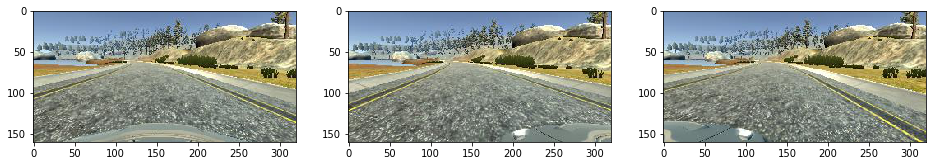

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline

unshuffled = generator(path, train_samples, batch_size=128, shuffle=False)
sample_images, _ = next(unshuffled)

# Left | Center | Right images
fig = plt.figure(figsize=(16,4))

for image_nb in [1,2,3]:
    fig.add_subplot(1,3,image_nb)
    sample_image = sample_images[2*(image_nb-1)]
    plt.imshow(sample_image)

plt.savefig('left-center-right_samples.png')

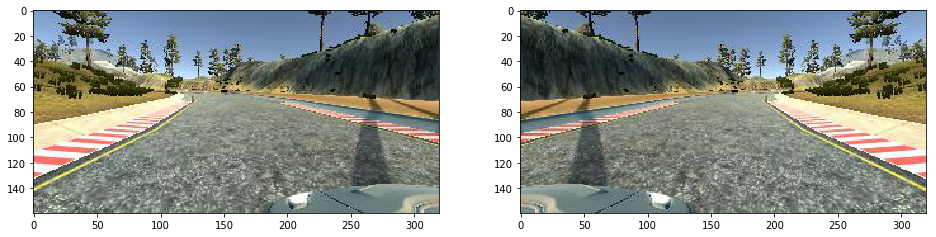

In [64]:
fig = plt.figure(figsize=(16,4))

for image_nb in [1,2]:
    fig.add_subplot(1,2,image_nb)
    sample_image = sample_images[151+image_nb]
    plt.imshow(sample_image)

plt.savefig('flipped_samples.png')

In [72]:
print("""-- Dataset information -- 
The dataset has {} training samples and {} validation samples. Each batch has {} images.
Each image has an original size of {}x{}x{} (color).""".format(len(train_samples)*6,\
                                                              len(validation_samples)*6,\
                                                              len(sample_images),\
                                                              sample_image.shape[0],\
                                                              sample_image.shape[1],\
                                                              sample_image.shape[2]))

-- Dataset information -- 
The dataset has 31962 training samples and 7992 validation samples. Each batch has 768 images.
Each image has an original size of 160x320x3 (color).


Model Architecture
---
This is where we define the convolutional neural network that learns how to drive autonomously. See `readme.md` for more explanations about this architecture.

In [22]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, Lambda, Cropping2D
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.backend import tf

In [23]:
def resize_im(x):
    from keras.backend import tf
    return tf.image.resize_images(x, (80, 160))

model = Sequential()
model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160,320,3)))
model.add(Lambda(lambda x: x / 127.5 - 1))
model.add(Lambda(resize_im))

# -- Convolutions
model.add(Convolution2D(16,3,3, activation='relu', border_mode='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32,3,3, activation='relu', border_mode='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(64,3,3, activation='relu', border_mode='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(128,3,3, activation='relu', border_mode='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# -- Flattening
model.add(Flatten())

# -- Dense layers
model.add(Dense(1000, activation='relu'))
model.add(Dropout(p=0.5))
model.add(Dense(100, activation='relu'))
model.add(Dropout(p=0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(p=0.5))

# -- Output
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

In [28]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cropping2d_5 (Cropping2D)        (None, 90, 320, 3)    0           cropping2d_input_5[0][0]         
____________________________________________________________________________________________________
lambda_9 (Lambda)                (None, 90, 320, 3)    0           cropping2d_5[0][0]               
____________________________________________________________________________________________________
lambda_10 (Lambda)               (None, 80, 160, 3)    0           lambda_9[0][0]                   
____________________________________________________________________________________________________
convolution2d_18 (Convolution2D) (None, 80, 160, 16)   448         lambda_10[0][0]                  
___________________________________________________________________________________________

Model Training
---
Below we train the model, print the training and validation error and finally save the model so that it can be used by the driving script.

Epoch 1/5
31962/31962 [==============================] - 62s - loss: 0.0260 - val_loss: 0.0060
Epoch 2/5
31962/31962 [==============================] - 62s - loss: 0.0095 - val_loss: 0.0043
Epoch 3/5
31962/31962 [==============================] - 62s - loss: 0.0082 - val_loss: 0.0040
Epoch 4/5
31962/31962 [==============================] - 62s - loss: 0.0077 - val_loss: 0.0039
Epoch 5/5
31962/31962 [==============================] - 62s - loss: 0.0074 - val_loss: 0.0035
dict_keys(['val_loss', 'loss'])


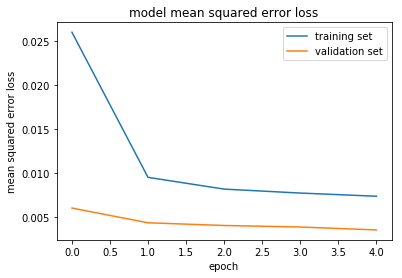

In [25]:
from keras.models import Model
import matplotlib.pyplot as plt

history_object = model.fit_generator(train_generator, 
                                     samples_per_epoch = len(train_samples)*6, 
                                     validation_data = validation_generator,    
                                     nb_val_samples = len(validation_samples)*6,     
                                     nb_epoch=5, 
                                     verbose=1)

model.save('model.h5')

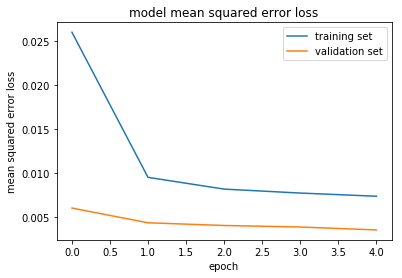

In [77]:
### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [81]:
metrics_train = model.evaluate_generator(train_generator,val_samples=5000)
metrics_valid = model.evaluate_generator(validation_generator,val_samples=5000)

In [85]:
metrics_valid

0.0027860864410521806

In [83]:
metrics_train

0.0030436030097512733